### Классификация по тональности

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.

### Часть 1. Анализ текстов

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('Materials/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:50, 1820.70it/s]


In [4]:
# пример отзыва
responses[2]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Двойное списание за один товар.',
 'num_comments': 1,
 'bank_license': 'лицензия № 2562',
 'author': 'Vladimir84',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-05 20:14:28',
 'text': 'Здравствуйте! \xa0Дублирую свое заявление от 03.06.2015 в ДО "Можайский". \xa002.06.2015 мною, по моей дебетовой карте была совершена покупка в интернет-магазине \xa0на сумму 3028 руб., но с карты произошло двойное списание (два раза по 3028 руб.) то есть 6056 руб. (о чем имеются смс сообщения от банка). Интернет-магазин подтвердил только один платеж 3028 руб. , товар был получен 05.06.2015. Прошу разобраться в ситуации и вернуть мне на счет ошибочно списанную сумму в размере 3028 руб.!  \xa0С уважением, давний клиент Вашего банка Владимир. Номер карты указан в моем заявлении в\xa0ДО "Можайский".',
 'rating_grade': None}

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


**1. Посчитайте количество отзывов в разных городах и на разные банки**

In [8]:
df_cities = df[['city', 'bank_name', 'title']].groupby(['city', 'bank_name']).count().reset_index()
df_cities.rename(columns={'title':'responce_count'}, inplace=True)
df_cities.head()

,city,bank_name,responce_count
0,г. (Красногорск),Транснациональный Банк,1
1,г. (Москва),Национальный Банк «Траст»,1
2,г. (Москва),Райффайзенбанк,1
3,г. (Россия),Кредит-Москва,1
4,г. (Ханты-Мансийский автономный округ),Киви Банк,1


In [9]:
len(df_cities.city.unique())

5823

Очевидно, что у одних и тех же городов могут быть разные варианты написания названия. Хорошо бы немного почистить датасет, чтобы разбиение отзывов по городам выглядело более релевантно. Попробую привести хотя бы часть названий городов к одному формату. Для начала уберу из названия скобки  

In [10]:
df_cities['city'] = df_cities['city'].str.replace('(', '')
df_cities['city'] = df_cities['city'].str.replace(')', '')
df_cities.head()

,city,bank_name,responce_count
0,г. Красногорск,Транснациональный Банк,1
1,г. Москва,Национальный Банк «Траст»,1
2,г. Москва,Райффайзенбанк,1
3,г. Россия,Кредит-Москва,1
4,г. Ханты-Мансийский автономный округ,Киви Банк,1


In [11]:
len(df_cities.city.unique())

5790

In [12]:
list(df_cities.city.unique())[:100]

['г.  Красногорск',
 'г.  Москва',
 'г.  Россия',
 'г.  Ханты-Мансийский автономный округ',
 'г. -',
 'г. ...',
 'г. ....',
 'г. .......',
 'г. ........',
 'г. 047169000 или 5939',
 'г. 1-е Новоспасское',
 'г. 111',
 'г. 1111',
 'г. 112',
 'г. 112422',
 'г. 140051, МО, Люберецкий район, Красково',
 'г. 140205,Pobeda street,16,39,city of Voscresensk,Moscow region',
 'г. 143420 Московская область, Красногорский район, посёлок дачного хозяйства Архангельское, д.4,кв.2',
 'г. 1Ёсаратов',
 'г. 2-я Гавриловка',
 'г. 21000, China, Jiangsu province, Nanjing',
 'г. 3 года с ТКС',
 'г. 312',
 'г. 5939 можно и так 047169000',
 'г. 5939 он же 047169000',
 'г. 636930, Томская обл., Первомайский р-н, с. Первомайское, ул. Советская, 11-4',
 'г. :erjdcrbq Москва',
 'г. :Жуковка',
 'г. ? видимо москва или новосибирск',
 'г. Astana',
 'г. Aрхангельск',
 'г. Back in USSR...',
 'г. Booischot, Belgium Москва',
 'г. Bremen Москва',
 'г. Bruxelles',
 'г. C-Пб',
 'г. C-Петербург',
 'г. Cg,',
 'г. Costa-Mesa',

Часть проблем, которая видна в начале списка уникальных названий городов из датасета:
- В названии есть явные ошибки (1Ёсаратов)
- название может быть написано латиницей (Omsk)
- название написано английскими буквами по русской раскладке (Rfpfym->Казань)
- название представляет собой сокращение (MSK)
- название включает в себя не только город (21000, China, Jiangsu province, Nanjing) 
- название включает в себя 2 города, непонятно, который из них основной (Moscow -- New York)
- название представляет собой комбинацию из цифр, символов или слов, из которых город понять невозможно (г. ...., г.111) 

In [13]:
len(df_cities.city.str.contains('г.')) == len(df_cities)

True

In [14]:
# Уберем сочетание "г." из названий городов
df_cities['city'] = df_cities['city'].str.replace('г.', '', regex=False)

Предположим, что если название не содержит ни одной буквы (только цифры или прочие символы), то вытащить название города из этого не получится. Заменяю такие сочетания на заглушку UNKNOWN 

In [4]:
import re


In [16]:
reg = r'^[^a-zA-Zа-яА-Я]+$'

In [17]:
df_cities['city'] = df_cities['city'].str.replace(reg, 'UNKNOWN', regex=True)

In [18]:
df_cities.head(15)

,city,bank_name,responce_count
0,Красногорск,Транснациональный Банк,1
1,Москва,Национальный Банк «Траст»,1
2,Москва,Райффайзенбанк,1
3,Россия,Кредит-Москва,1
4,Ханты-Мансийский автономный округ,Киви Банк,1
5,UNKNOWN,Сбербанк России,1
6,UNKNOWN,Авангард,2
7,UNKNOWN,Авангард,1
8,UNKNOWN,Альфа-Банк,1
9,UNKNOWN,Ханты-Мансийский банк Открытие,1


In [19]:
# сгруппирую, чтобы сложить дубликаты строк
df_cities = df_cities.groupby(['city', 'bank_name']).sum().reset_index()
df_cities.head()

,city,bank_name,responce_count
0,Железнодорожный,Соцгорбанк,1
1,Азов,Сбербанк России,1
2,Алексеевка Белгородская область,Сбербанк России,1
3,Амурск,Хоум Кредит Банк,1
4,"Ахтубинск, Астраханская обл.",Сбербанк России,1


In [20]:
len(df_cities.city.unique())

5682

In [21]:
! pip install transliterate

In [5]:
from transliterate import translit

Переведу названия, написанные транслитом на латинице, на русский 

In [23]:
def translit_to_ru(row):
    return translit(row, 'ru')
        

In [24]:
df_cities['city'] = df_cities['city'].apply(translit_to_ru)

In [25]:
len(df_cities.city.unique())

5639

In [26]:
list(df_cities.city.unique())[:50]

['   Железнодорожный',
 '  Азов',
 '  Алексеевка Белгородская область',
 '  Амурск',
 '  Ахтубинск, Астраханская обл.',
 '  Ашхабад, Туркменистан',
 '  Барнаул',
 '  Березовский',
 '  Березовский Свердловская область',
 '  Богородицк Тульская облась',
 '  Бор Нижегородской области',
 '  Бор, Нижегородская область Нижний Новгород',
 '  Бород',
 '  Бугульма',
 '  Волгоград',
 '  Волгодонск',
 '  Волжск',
 '  Волжский Волгоградской обл.',
 '  Волжский Волгоградской области',
 '  Воркута',
 '  Воронеж',
 '  Всеволожск, Ленинградская обл.',
 '  Геленджик с.Дивноморское',
 '  Горно-Алтайск',
 '  Долгопрудный',
 '  Домодедово',
 '  Ейск',
 '  Екатеринбург',
 '  Железнодорожный',
 '  Жуковский',
 '  Жуковский, МО',
 '  Заполярный Мурманская область Мурманск',
 '  Зеленоград',
 '  Иванново',
 '  Иваново',
 '  Иркутск',
 '  Йошкар-Ола',
 '  Калачинск',
 '  Калининград',
 '  Калуга',
 '  Кашин, Тверская область',
 '  Кашира',
 '  Кингисепп',
 '  Киров',
 '  Киров, Кировская область',
 '  Кировск'

In [27]:
# сгруппирую, чтобы сложить дубликаты строк
df_cities = df_cities.groupby(['city', 'bank_name']).sum().reset_index()
df_cities.head()

,city,bank_name,responce_count
0,Железнодорожный,Соцгорбанк,1
1,Азов,Сбербанк России,1
2,Алексеевка Белгородская область,Сбербанк России,1
3,Амурск,Хоум Кредит Банк,1
4,"Ахтубинск, Астраханская обл.",Сбербанк России,1


Приведем все названия к lower-кейсу. Возможно, это тоже схлопнет часть названий городов 

In [28]:
df_cities['city'] = df_cities['city'].str.lower()
df_cities['city'] = df_cities['city'].str.strip()
df_cities.head()

,city,bank_name,responce_count
0,железнодорожный,Соцгорбанк,1
1,азов,Сбербанк России,1
2,алексеевка белгородская область,Сбербанк России,1
3,амурск,Хоум Кредит Банк,1
4,"ахтубинск, астраханская обл.",Сбербанк России,1


In [29]:
# сгруппирую, чтобы сложить дубликаты строк
df_cities = df_cities.groupby(['city', 'bank_name']).sum().reset_index()
df_cities.head()

,city,bank_name,responce_count
0,047169000 или 5939,Сбербанк России,1
1,1-е новоспасское,Уралсиб,1
2,"140051, мо, люберецкий район, красково",Сбербанк России,1
3,"140205,победа стреет,16,39,циты оф восцресенск...",ОТП Банк,1
4,"143420 московская область, красногорский район...",Банк Москвы,1


In [30]:
len(df_cities.city.unique())

4959

In [31]:
list(df_cities.city.unique())[:100]

['047169000 или 5939',
 '1-е новоспасское',
 '140051, мо, люберецкий район, красково',
 '140205,победа стреет,16,39,циты оф восцресенск,мосцоw регион',
 '143420 московская область, красногорский район, посёлок дачного хозяйства архангельское, д.4,кв.2',
 '1ёсаратов',
 '2-я гавриловка',
 '21000, чина, йиангсу провинце, нанйинг',
 '3 года с ткс',
 '5939 можно и так 047169000',
 '5939 он же 047169000',
 '636930, томская обл., первомайский р-н, с. первомайское, ул. советская, 11-4',
 ':ерйдцрбq москва',
 ':жуковка',
 '? видимо москва или новосибирск',
 '\\бобруйск :',
 'wатербуры',
 'wиннипег, цанада',
 'а-вск',
 'абага амгинский р-н',
 'абаза',
 'абакан',
 'абакан абакан',
 'абакан москва',
 'абакан республика хакасия',
 'абатское',
 'абашево',
 'абдулино',
 'абзелиловский р-н, с.аскарово',
 'абинск',
 'абинск краснодарский край',
 'абинский район поселок ахтырский',
 'абрамово',
 'аван хабаровский край вяземсий район хабаровск',
 'авсюнино',
 'агалатово',
 'агаповка',
 'агвали',
 'агидел

Транслитерация почему-то не заменила букву w. Заменю вручную w на в

In [32]:
df_cities['city'] = df_cities['city'].str.replace('w', 'в', regex = False)

In [6]:
from nltk import word_tokenize

Для простоты предположим, что первое слово из всего адреса и есть название города. Это справедливо не для всего датасета, но, похоже, надо обучать отдельно модель по названиям городов, чтобы корректно извлечь их с учетом всех возможных форм написания и ошибок

In [34]:
df_cities['city_token'] = df_cities['city'].apply(word_tokenize)

In [35]:
df_cities.head()

,city,bank_name,responce_count,city_token
0,047169000 или 5939,Сбербанк России,1,"[047169000, или, 5939]"
1,1-е новоспасское,Уралсиб,1,"[1-е, новоспасское]"
2,"140051, мо, люберецкий район, красково",Сбербанк России,1,"[140051, ,, мо, ,, люберецкий, район, ,, краск..."
3,"140205,победа стреет,16,39,циты оф восцресенск...",ОТП Банк,1,"[140205, ,, победа, стреет,16,39, ,, циты, оф,..."
4,"143420 московская область, красногорский район...",Банк Москвы,1,"[143420, московская, область, ,, красногорский..."


In [36]:
df_cities['city'] = df_cities['city_token'].apply(lambda x: x[0])

In [37]:
df_cities.head()

,city,bank_name,responce_count,city_token
0,047169000,Сбербанк России,1,"[047169000, или, 5939]"
1,1-е,Уралсиб,1,"[1-е, новоспасское]"
2,140051,Сбербанк России,1,"[140051, ,, мо, ,, люберецкий, район, ,, краск..."
3,140205,ОТП Банк,1,"[140205, ,, победа, стреет,16,39, ,, циты, оф,..."
4,143420,Банк Москвы,1,"[143420, московская, область, ,, красногорский..."


In [38]:
# сгруппирую, чтобы сложить дубликаты строк
df_cities = df_cities.groupby(['city', 'bank_name']).sum().reset_index()
df_cities.head()

,city,bank_name,responce_count
0,047169000,Сбербанк России,1
1,1-е,Уралсиб,1
2,140051,Сбербанк России,1
3,140205,ОТП Банк,1
4,143420,Банк Москвы,1


In [39]:
len(df_cities.city.unique())

2506

In [40]:
reg = r'^[^a-zA-Zа-яА-Я]+$'
df_cities['city'] = df_cities['city'].str.replace(reg, 'UNKNOWN', regex=True)

In [41]:
# сгруппирую, чтобы сложить дубликаты строк
df_cities = df_cities.groupby(['city', 'bank_name']).sum().reset_index()
df_cities.head()

,city,bank_name,responce_count
0,1-е,Уралсиб,1
1,1ёсаратов,Ренессанс Кредит,1
2,2-я,Сбербанк России,1
3,UNKNOWN,Альфа-Банк,1
4,UNKNOWN,Банк Москвы,1


Как промежуточный итог: не все ошибки убраны из датасета и не все названия городов извлечены корректно. Однако количество уникальных названий городов сократилось с 5823 до 2506 элементов, что даст более адекватную картину распределения количества отзывов по городам.

Собственно, теперь выведем по заданию, какое количество отзывов относится к различным городам и различным банкам. 

In [42]:
df_cities_only = df_cities.groupby(['city']).sum().reset_index()
df_cities_only = df_cities_only.sort_values('responce_count', ascending=False)
df_cities_only.head()

,city,responce_count
1156,москва,57178
1872,санкт-петербург,14759
1384,новосибирск,2394
529,екатеринбург,2393
1318,нижний,2279


<AxesSubplot:xlabel='city'>

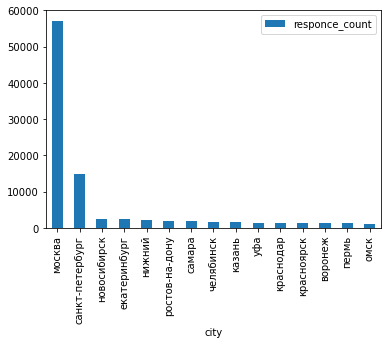

In [43]:
# выведем наиболее часто встречающиеся города
df_cities_only.set_index('city').head(15).plot(kind='bar')

In [44]:
df_banks_only = df_cities.groupby(['bank_name']).sum().reset_index()
df_banks_only = df_banks_only.sort_values('responce_count', ascending=False)
df_banks_only.head()

,bank_name,responce_count
449,Сбербанк России,25521
32,Альфа-Банк,9059
560,Хоум Кредит Банк,7337
98,ВТБ 24,7307
432,Русский Стандарт,7194


<AxesSubplot:xlabel='bank_name'>

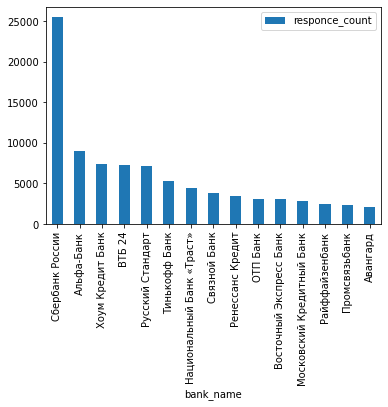

In [45]:
df_banks_only.set_index('bank_name').head(15).plot(kind='bar')

**2. Постройте гистограмы длин слов в символах и в словах**

Строить буду непосредственно на текстах отзывов

In [47]:
all_responces = df.text.to_list()
all_responces[0]

'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,\xa0 и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют мн

In [51]:
ru_words = re.compile("[А-Яа-я]+")

def words_only(text):
    return " ".join(ru_words.findall(text))

In [53]:
all_rus_words = [words_only(all_responces[i]).split() for i in range(len(all_responces))]
all_rus_words[0]

['Добрый',
 'день',
 'Я',
 'не',
 'являюсь',
 'клиентом',
 'банка',
 'и',
 'поручителем',
 'по',
 'кредитному',
 'договору',
 'а',
 'также',
 'не',
 'являюсь',
 'каким',
 'либо',
 'другим',
 'лицом',
 'письменно',
 'оформившим',
 'отношения',
 'с',
 'банком',
 'по',
 'поводу',
 'урегулирования',
 'чьей',
 'либо',
 'задолженности',
 'Начиная',
 'с',
 'марта',
 'года',
 'начали',
 'приходить',
 'бесконечные',
 'письма',
 'из',
 'ООО',
 'Примо',
 'коллект',
 'на',
 'мой',
 'адрес',
 'город',
 'Москва',
 'Уваровский',
 'переулок',
 'дом',
 'квартира',
 'с',
 'угрозами',
 'о',
 'возбуждении',
 'уголовного',
 'дела',
 'в',
 'отношении',
 'гражданина',
 'Филиппова',
 'Эдуарда',
 'Владимировича',
 'который',
 'уклоняется',
 'от',
 'уплаты',
 'взятых',
 'им',
 'кредитов',
 'договор',
 'от',
 'года',
 'и',
 'договор',
 'от',
 'года',
 'Со',
 'всей',
 'ответственностью',
 'хочу',
 'Вас',
 'заверить',
 'что',
 'вышеуказанный',
 'гражданин',
 'которого',
 'Вы',
 'разыскиваете',
 'мне',
 'не',
 'зна

In [54]:
# Получился список списков, развернем его в одномерный список
all_rus_words = [item for sublist in all_rus_words for item in sublist]
all_rus_words[0]

'Добрый'

In [63]:
# создаю словарь, в котором ключи будут длины слов, значения - количество слов соответствующей длины
len_in_chars = {}

for word in all_rus_words:
#     если такая длина слова уже есть в словаре, увеличиваю значение на единицу, иначе заношу новый ключ
    if len_in_chars.get(len(word)):
        len_in_chars[len(word)] +=1
    else:
        len_in_chars[len(word)] = 1
    

In [66]:
sorted(len_in_chars.items())


[(1, 4515472),
 (2, 3897962),
 (3, 4019032),
 (4, 2900976),
 (5, 4370298),
 (6, 3791372),
 (7, 3144115),
 (8, 2708775),
 (9, 2379698),
 (10, 1455175),
 (11, 909581),
 (12, 567720),
 (13, 375984),
 (14, 202272),
 (15, 104531),
 (16, 49893),
 (17, 16664),
 (18, 10617),
 (19, 4090),
 (20, 2061),
 (21, 583),
 (22, 865),
 (23, 438),
 (24, 1035),
 (25, 95),
 (26, 34),
 (27, 10),
 (28, 2),
 (29, 3),
 (30, 5),
 (32, 2),
 (34, 3),
 (35, 1),
 (39, 1),
 (40, 1),
 (45, 1),
 (50, 1),
 (61, 1),
 (66, 1),
 (73, 1),
 (80, 1),
 (82, 1)]

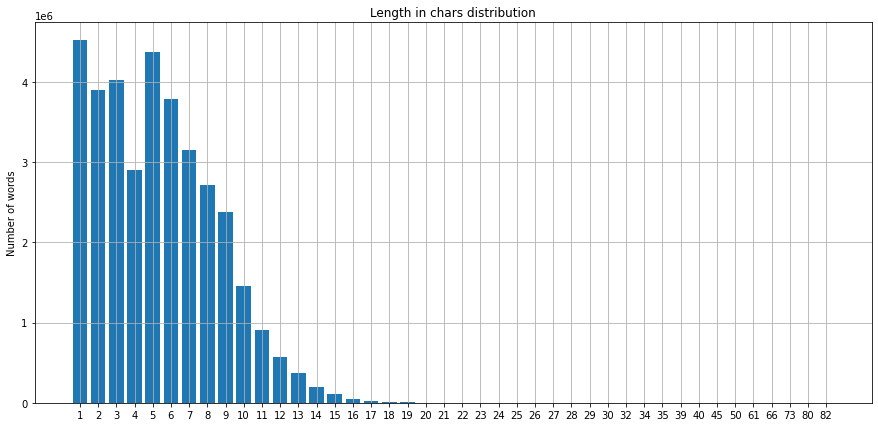

In [77]:
len_words = [x[0] for x in sorted(len_in_chars.items())]
score = [x[1] for x in sorted(len_in_chars.items())]
x_pos = np.arange(len(len_words)) 

plt.figure(figsize=(15, 7))
plt.bar(x_pos, score,align='center')
plt.xticks(x_pos, len_words) 
plt.ylabel('Number of words')
plt.title('Length in chars distribution')
plt.grid()
plt.show()

Интересно, что за слова состоят из более чем 20 букв. Скорее всего это какие-то ошибочные написания, например, без пробелов

Теперь посмотрим на распределение по количеству слов в отзывах

In [78]:
all_responces = df.text.to_list()
all_responces_cleaned = [words_only(all_responces[i]).split() for i in range(len(all_responces))]

In [79]:
len_in_words = {}

for responce in all_responces_cleaned:
    if len_in_chars.get(len(responce)):
        len_in_chars[len(responce)] +=1
    else:
        len_in_chars[len(responce)] = 1
        
len_in_words = sorted(len_in_chars.items())

In [80]:
len_in_words

[(0, 2),
 (1, 4515472),
 (2, 3897962),
 (3, 4019032),
 (4, 2900980),
 (5, 4370300),
 (6, 3791374),
 (7, 3144119),
 (8, 2708787),
 (9, 2379709),
 (10, 1455195),
 (11, 909591),
 (12, 567734),
 (13, 375994),
 (14, 202288),
 (15, 104545),
 (16, 49905),
 (17, 16684),
 (18, 10643),
 (19, 4111),
 (20, 2092),
 (21, 614),
 (22, 899),
 (23, 470),
 (24, 1068),
 (25, 146),
 (26, 79),
 (27, 78),
 (28, 45),
 (29, 74),
 (30, 63),
 (31, 63),
 (32, 86),
 (33, 68),
 (34, 95),
 (35, 100),
 (36, 89),
 (37, 113),
 (38, 131),
 (39, 160),
 (40, 184),
 (41, 229),
 (42, 268),
 (43, 285),
 (44, 371),
 (45, 403),
 (46, 441),
 (47, 455),
 (48, 455),
 (49, 514),
 (50, 537),
 (51, 521),
 (52, 494),
 (53, 512),
 (54, 510),
 (55, 510),
 (56, 530),
 (57, 489),
 (58, 474),
 (59, 533),
 (60, 498),
 (61, 506),
 (62, 517),
 (63, 485),
 (64, 500),
 (65, 516),
 (66, 554),
 (67, 530),
 (68, 561),
 (69, 557),
 (70, 535),
 (71, 523),
 (72, 545),
 (73, 572),
 (74, 577),
 (75, 563),
 (76, 589),
 (77, 589),
 (78, 554),
 (79, 607)

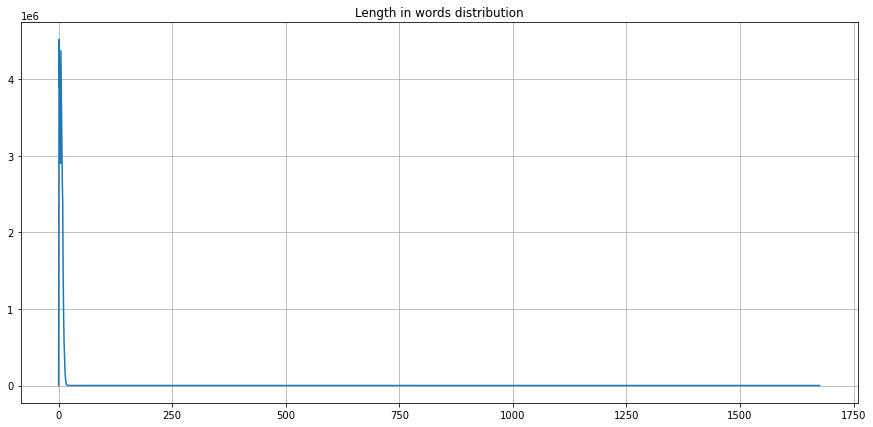

In [88]:
len_words = [x[0] for x in len_in_words]
score = [x[1] for x in len_in_words]
x_pos = np.arange(len(len_words)) 

plt.figure(figsize=(15, 7))
plt.plot(x_pos, score)
plt.title('Length in words distribution')
plt.grid()
plt.show()

Для большей наглядности разобьем на 2 графика: отдельно для отзывов с длиной, не превышающей 25 слов, отдельно для прочих  

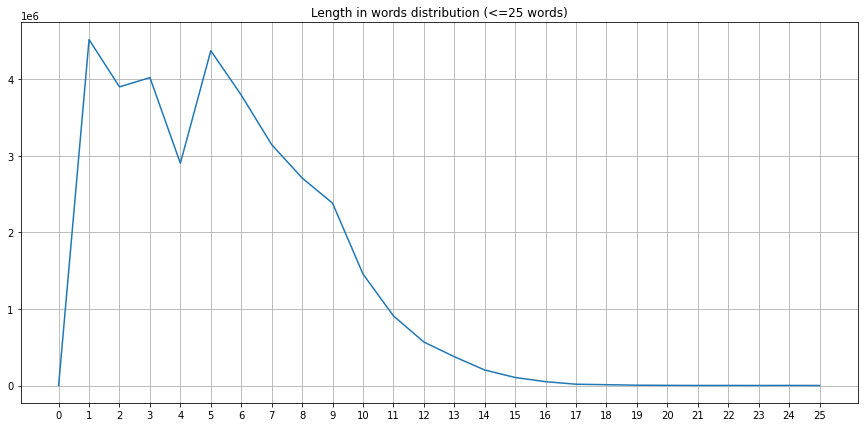

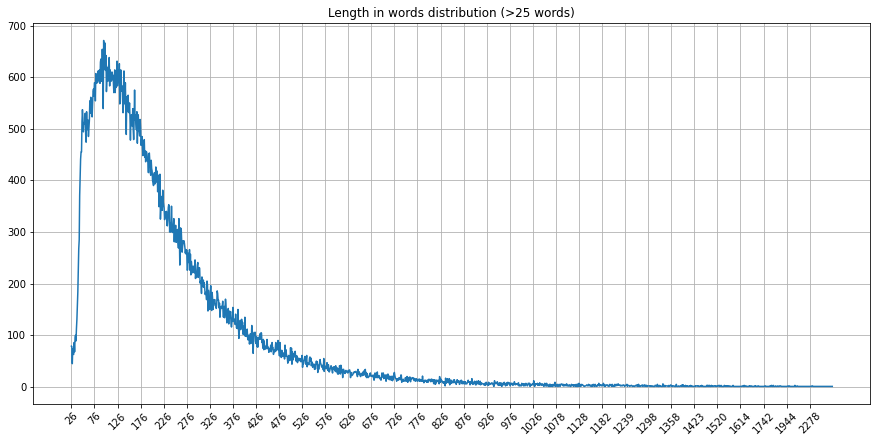

In [100]:
plt.figure(figsize=(15, 7))
plt.plot(x_pos[:26], score[:26])
plt.xticks(x_pos[:26], len_words[:26])
plt.title('Length in words distribution (<=25 words)')
plt.grid()
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(x_pos[26:], score[26:])
plt.xticks(x_pos[26::50], len_words[26::50], rotation=45)
plt.title('Length in words distribution (>25 words)')
plt.grid()
plt.show()

**3. Найдите 10 самых частых:**
- слов
- слов без стоп-слов
- лемм
- существительных

In [102]:
# приведем все слова к lower-кейсу
all_rus_words = [word.lower() for word in all_rus_words]

In [7]:
from collections import Counter

In [105]:
freq_dict = Counter(all_rus_words)

# 10 самых частотных слов
freq_dict.most_common(10)

[('в', 1330550),
 ('и', 1058997),
 ('не', 855335),
 ('на', 707935),
 ('что', 640057),
 ('я', 577500),
 ('с', 464037),
 ('по', 372769),
 ('мне', 320958),
 ('банка', 275906)]

In [8]:
from nltk.corpus import stopwords

In [111]:
without_stopwords = [word for word in all_rus_words if not word in stopwords.words('russian')]

In [112]:
freq_dict = Counter(without_stopwords)

# 10 самых частотных слов без стоп-слов
freq_dict.most_common(10)

[('банка', 275906),
 ('банк', 215426),
 ('это', 183365),
 ('деньги', 131201),
 ('карту', 105829),
 ('карты', 101821),
 ('т', 91756),
 ('кредит', 81136),
 ('день', 76552),
 ('банке', 72169)]

In [9]:
import pymorphy2


In [112]:
morph = pymorphy2.MorphAnalyzer()

In [122]:
def lemmatize(text):
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return res

In [123]:
text = "Съешь еще этих мягких французских булок да выпей чаю"
lemmatize(text)

['съесть',
 'ещё',
 'этот',
 'мягкий',
 'французский',
 'булка',
 'да',
 'выпить',
 'чай']

In [115]:
# записываю в файл. достаточно долго формировался список без стоп-слов,если придется формировать снова, прочитать будет быстрее
with open('without_stopwords.txt','w', encoding='utf-8') as f:
    for item in without_stopwords:
        f.write("%s\n" % item)

In [125]:
lemmatized = lemmatize(' '.join(without_stopwords))

In [11]:
# lemmatized_ = []

# with open('lemmatized.txt', 'r', encoding='utf-8') as f:
#     for line in f:
#         lemmatized_.append(line.strip())

In [12]:
# lemmatized_[0]

'добрый'

In [15]:
# freq_dict = Counter(lemmatized_)

In [126]:
freq_dict = Counter(lemmatized)

# 10 самых частых лемм
freq_dict.most_common(10)

[('банк', 668563),
 ('карта', 334999),
 ('это', 200057),
 ('деньга', 179819),
 ('день', 173116),
 ('мой', 163042),
 ('кредит', 156177),
 ('который', 149017),
 ('отделение', 144050),
 ('клиент', 136892)]

In [128]:
# записываю в файл, прочитать будет быстрее
with open('lemmatized.txt','w', encoding='utf-8') as f:
    for item in lemmatized:
        f.write("%s\n" % item)

In [136]:
nouns = []

for word in lemmatized:
    lemma = morph.parse(word)[0]
    if lemma.tag.POS == 'NOUN':
        nouns.append(lemma) 
    

In [137]:
freq_dict_nouns = Counter(nouns)

# 10 самых частых существительных
freq_dict_nouns.most_common(10)

[(Parse(word='банк', tag=OpencorporaTag('NOUN,inan,masc sing,nomn'), normal_form='банк', score=0.653846, methods_stack=((DictionaryAnalyzer(), 'банк', 19, 0),)),
  668563),
 (Parse(word='карта', tag=OpencorporaTag('NOUN,inan,femn sing,nomn'), normal_form='карта', score=1.0, methods_stack=((DictionaryAnalyzer(), 'карта', 55, 0),)),
  334999),
 (Parse(word='деньга', tag=OpencorporaTag('NOUN,inan,femn sing,nomn,Infr'), normal_form='деньга', score=1.0, methods_stack=((DictionaryAnalyzer(), 'деньга', 1328, 0),)),
  179819),
 (Parse(word='день', tag=OpencorporaTag('NOUN,inan,masc sing,accs'), normal_form='день', score=0.745454, methods_stack=((DictionaryAnalyzer(), 'день', 1327, 3),)),
  173116),
 (Parse(word='кредит', tag=OpencorporaTag('NOUN,inan,masc sing,accs'), normal_form='кредит', score=0.833333, methods_stack=((DictionaryAnalyzer(), 'кредит', 34, 3),)),
  156177),
 (Parse(word='отделение', tag=OpencorporaTag('NOUN,inan,neut sing,accs'), normal_form='отделение', score=0.6, methods_sta

In [144]:
nouns_ = [nouns[i].word for i in range(len(nouns))]

In [145]:
freq_dict_nouns = Counter(nouns_)

# 10 самых частых существительных
freq_dict_nouns.most_common(10)

[('банк', 668563),
 ('карта', 334999),
 ('деньга', 179819),
 ('день', 173116),
 ('кредит', 156177),
 ('отделение', 144050),
 ('клиент', 136892),
 ('сотрудник', 134168),
 ('счёт', 126894),
 ('сумма', 111232)]

**4. Постройте кривые Ципфа и Хипса**

In [10]:
from string import punctuation

In [80]:
freqs = list(freq_dict.values()) # возвращаюсь к предыдущему частотному словарю, чтобы учитывать не только существительные
freqs = sorted(freqs, reverse = True)

In [104]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))


100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [1:38:09<00:00, 26.06it/s]


In [106]:
n_words[:10]

[170, 268, 319, 398, 551, 601, 648, 710, 770, 854]

In [107]:
n_tokens[:10]

[222, 358, 451, 575, 883, 969, 1058, 1159, 1254, 1453]

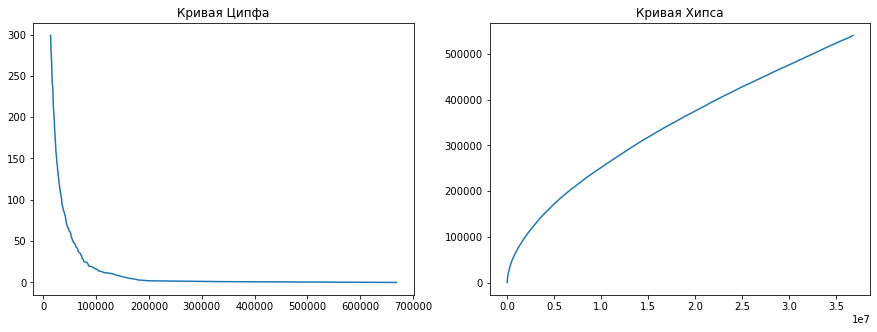

In [108]:
fig, axes = plt.subplots(1, 2,figsize=(15, 5))

axes[0].plot(freqs[:300], range(300))
axes[0].set_title('Кривая Ципфа')

axes[1].plot(n_tokens, n_words)
axes[1].set_title('Кривая Хипса')

plt.show()

**5. Ответьте на следующие вопросы:**
 - какое слово встречается чаще, "сотрудник" или "клиент"?
 - сколько раз встречается слова "мошенничество" и "доверие"?

In [148]:
print(f'Слово "сотрудник" встречается {freq_dict_nouns["сотрудник"]} раз(а)')
print(f'Слово "клиент" встречается {freq_dict_nouns["клиент"]} раз(а)')
print(f'Слово "мошенничество" встречается {freq_dict_nouns["мошенничество"]} раз(а)')
print(f'Слово "доверие" встречается {freq_dict_nouns["доверие"]} раз(а)')

Слово "сотрудник" встречается 134168 раз(а)
Слово "клиент" встречается 136892 раз(а)
Слово "мошенничество" встречается 3244 раз(а)
Слово "доверие" встречается 2108 раз(а)


"Сотрудник" реже, чем "Клиент", "мошенничество" чаще, чем "доверие" 

**6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)**

In [27]:
df_ratings_1 = df[df['rating_grade'] == 1]
df_ratings_5 = df[df['rating_grade'] == 5]

In [29]:
df_ratings_5.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
98,г. Санкт-Петербург,False,"Хорошо, когда проблемы решаются",0,лицензия № 1073,apka45,Русславбанк,2015-06-03 17:40:38,Досрочно закрывали вклады перед отпуском. Жена...,5.0
122,г. Нижний Новгород,False,Изменяют проценты по уже открытому договору вк...,3,лицензия № 226,20157673,РосинтерБанк,2015-06-04 09:38:18,"Хотел открыть вклад ""Доходный+"" под 19% год , ...",5.0
157,г. Москва,False,"Отделение Марксистская, дом 5: спасибо за помощь!",0,лицензия № 1623,ospar,ВТБ 24,2015-06-04 22:58:38,"Вчера, 3 июня, просидев в очереди более 3-х ча...",5.0
259,г. Москва,False,Хорошее обслуживание,0,лицензия № 3206,ser-gyr,Соверен Банк,2015-06-02 18:23:41,Сегодня открывал вклад в этом банке. Очередь б...,5.0
266,г. Москва,False,Моя история получения кредита в Ренессанс Кред...,1,лицензия № 3354,SkaIa,Ренессанс Кредит,2015-06-03 02:03:28,Моя история получения кредита в Ренессанс Кред...,5.0


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [41]:
stops = stopwords.words('russian')+[char for char in punctuation]

Обучение tf-idf проведу на полном корпусе. Искать ключевые слова буду в отфильтрованных данных

In [43]:
docs = df.text.to_list()

In [46]:
cv = CountVectorizer(ngram_range=(1, 1), stop_words=stops)
word_count_vector=cv.fit_transform(docs)


In [47]:
word_count_vector.shape

(153499, 346827)

Количество фич очень велико. Ограничу размер обучаемого словаря с помощью max_features, 10000 наиболее частотных слов должно быть достаточно для выполнения задачи

In [48]:
cv = CountVectorizer(ngram_range=(1, 1), stop_words=stops, max_features=10000)
word_count_vector=cv.fit_transform(docs)

In [49]:
word_count_vector.shape

(153499, 10000)

In [50]:
feature_names = cv.get_feature_names()
feature_names[:10]

['00',
 '000',
 '000107',
 '000407',
 '000912',
 '000913',
 '000р',
 '002207',
 '01',
 '02']

In [60]:
trans=TfidfTransformer(smooth_idf=True)
trans.fit(word_count_vector)

TfidfTransformer()

In [59]:
# вспомогательные функции для получения наиболее значимых ключевых слов

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""

    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [63]:
# проверим на 1 документе
doc_test=df_ratings_1.iloc[0].text

tf_idf_vector=trans.transform(cv.transform([doc_test]))
sorted_items=sort_coo(tf_idf_vector.tocoo())

# извлекаю 5 ключевых слов
keywords=extract_topn_from_vector(feature_names,sorted_items,5)

print("\n=====Text=====")
print(doc_test)

print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


=====Text=====
Открыт вклад и счет в USD. Плюс к этому есть зарплатная карта, в рублях, само собой. Сегодня пришел в указанное отделение с целью пополнить долларовый счёт на 700 USD. Дал операционисту паспорт, зарплатную карту (т.к. на окошке написано "приготовьте карту для подтверждения операции" или что-то подобное и в прошлый раз у меня ее потребовали) и сказал, что нужно положить деньги на ДОЛЛАРОВЫЙ счет. Операционист всё взяла, что-то делала-крутила-вертела, вставила карту в терминал, сказала "введите пин", я ввёл пин, получил в ответ чек, где было написано, что доллары были внесены.... на счёт КАРТЫ! в РУБЛЯХ! Вопрос банку №1, риторический:  Я не понимаю, кем нужно быть, чтобы сознательно проводить такие операции??? за углом, меньше чем через квартал, курс приёма валюты выше почти на рубль! Если я действительно хотел совершить такую "хитрую" операцию, мне было выгоднее сделать 100 шагов и "заработать" на этом около 700 рублей, после чего просто внести рубли на счёт карты в банк

In [76]:
def extract_keywords_in_docs_list(docs_list, cv, trans, feature_names):

    tf_idf_vector=trans.transform(cv.transform(docs_list))

    results=[]
    for i in range(tf_idf_vector.shape[0]):

        curr_vector=tf_idf_vector[i]
        sorted_items=sort_coo(curr_vector.tocoo())
        keywords=extract_topn_from_vector(feature_names,sorted_items,5)

        results.append(keywords)

    df_results=pd.DataFrame(zip(docs,results),columns=['doc','keywords'])
    return df_results
    

In [66]:
# выделим ключевые слова для отзывов с рейтингом 1

docs_1 = df_ratings_1.text.to_list()
df_results_1 = extract_keywords_in_docs_list(docs_1, cv, trans, feature_names)


In [67]:
df_results_1.head()

,doc,keywords
0,Добрый день! Я не являюсь клиентом банка и пор...,"{'счёт': 0.308, 'долларовый': 0.243, '54': 0.2..."
1,Доброго дня! Являюсь держателем зарплатной кар...,"{'страховки': 0.42, 'одобренный': 0.281, 'стра..."
2,Здравствуйте! Дублирую свое заявление от 03.0...,"{'взносы': 0.251, 'договора': 0.239, 'дополнит..."
3,Добрый день!! Я открыл расчетный счет в СберБа...,"{'найден': 0.481, 'счет': 0.248, 'лицевой': 0...."
4,"04.03.2015 г. взяла кредит в вашем банке, заяв...","{'квитанции': 0.323, 'положила': 0.252, 'подав..."


In [68]:
# выделим ключевые слова для отзывов с рейтингом 5

docs_5 = df_ratings_5.text.to_list()
df_results_5 = extract_keywords_in_docs_list(docs_5, cv, trans, feature_names)

In [69]:
df_results_5.head()

,doc,keywords
0,Добрый день! Я не являюсь клиентом банка и пор...,"{'вклады': 0.303, 'закрывали': 0.24, 'лишнего'..."
1,Доброго дня! Являюсь держателем зарплатной кар...,"{'доходный': 0.368, 'вклада': 0.294, 'вклад': ..."
2,Здравствуйте! Дублирую свое заявление от 03.0...,"{'выплат': 0.308, 'июня': 0.229, 'просидев': 0..."
3,Добрый день!! Я открыл расчетный счет в СберБа...,"{'отмечу': 0.325, 'наличие': 0.284, 'зав': 0.1..."
4,"04.03.2015 г. взяла кредит в вашем банке, заяв...","{'страховки': 0.218, 'кредита': 0.185, 'пора':..."


повторим для биграмм

In [72]:
cv_2 = CountVectorizer(ngram_range=(2, 2), stop_words=stops, max_features=10000)
word_count_vector_2=cv_2.fit_transform(docs)

In [73]:
feature_names_2 = cv_2.get_feature_names()
feature_names_2[:10]

['00 00',
 '00 05',
 '00 14',
 '00 15',
 '00 16',
 '00 17',
 '00 18',
 '00 19',
 '00 20',
 '00 21']

In [74]:
trans_2=TfidfTransformer(smooth_idf=True)
trans_2.fit(word_count_vector_2)

TfidfTransformer()

In [75]:
# проверим на 1 документе
doc_test=df_ratings_1.iloc[0].text

tf_idf_vector=trans_2.transform(cv_2.transform([doc_test]))
sorted_items=sort_coo(tf_idf_vector.tocoo())

# извлекаю 5 ключевых слов
keywords=extract_topn_from_vector(feature_names_2,sorted_items,5)

print("\n=====Text=====")
print(doc_test)

print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


=====Text=====
Открыт вклад и счет в USD. Плюс к этому есть зарплатная карта, в рублях, само собой. Сегодня пришел в указанное отделение с целью пополнить долларовый счёт на 700 USD. Дал операционисту паспорт, зарплатную карту (т.к. на окошке написано "приготовьте карту для подтверждения операции" или что-то подобное и в прошлый раз у меня ее потребовали) и сказал, что нужно положить деньги на ДОЛЛАРОВЫЙ счет. Операционист всё взяла, что-то делала-крутила-вертела, вставила карту в терминал, сказала "введите пин", я ввёл пин, получил в ответ чек, где было написано, что доллары были внесены.... на счёт КАРТЫ! в РУБЛЯХ! Вопрос банку №1, риторический:  Я не понимаю, кем нужно быть, чтобы сознательно проводить такие операции??? за углом, меньше чем через квартал, курс приёма валюты выше почти на рубль! Если я действительно хотел совершить такую "хитрую" операцию, мне было выгоднее сделать 100 шагов и "заработать" на этом около 700 рублей, после чего просто внести рубли на счёт карты в банк

In [77]:
# выделим ключевые биграммы для отзывов с рейтингом 1

df_results_1_bigramms = extract_keywords_in_docs_list(docs_1, cv_2, trans_2, feature_names_2)
df_results_1_bigramms.head()

,doc,keywords
0,Добрый день! Я не являюсь клиентом банка и пор...,"{'подтверждения операции': 0.376, 'счёт карты'..."
1,Доброго дня! Являюсь держателем зарплатной кар...,"{'кредит сотрудник': 0.193, 'одобренный кредит..."
2,Здравствуйте! Дублирую свое заявление от 03.0...,"{'го июня': 0.304, '05 06': 0.282, 'течение ср..."
3,Добрый день!! Я открыл расчетный счет в СберБа...,"{'возможность пополнения': 0.342, 'пластиковой..."
4,"04.03.2015 г. взяла кредит в вашем банке, заяв...","{'свой счет': 0.351, '02 06': 0.24, 'итоге ска..."


In [78]:
# выделим ключевые биграммы для отзывов с рейтингом 5

df_results_5_bigramms = extract_keywords_in_docs_list(docs_5, cv_2, trans_2, feature_names_2)
df_results_5_bigramms.head()

,doc,keywords
0,Добрый день! Я не являюсь клиентом банка и пор...,"{'банка спб': 0.675, 'быстро профессионально':..."
1,Доброго дня! Являюсь держателем зарплатной кар...,"{'счет вклада': 0.497, 'открыли счет': 0.32, '..."
2,Здравствуйте! Дублирую свое заявление от 03.0...,"{'00 22': 0.285, 'закрытия отделения': 0.285, ..."
3,Добрый день!! Я открыл расчетный счет в СберБа...,"{'зав отделением': 0.357, 'одном другом': 0.35..."
4,"04.03.2015 г. взяла кредит в вашем банке, заяв...","{'1200 рублей': 0.216, 'информацию обо': 0.215..."


### Часть 2. Тематическое моделирование

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim.

Вначале предобработаем данные в самом датафрейме

In [109]:
df_copy = df.copy()

In [115]:
mystopwords = stops + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmatize(text, mystem=morph):
    try:
        words = text.split() # разбиваем текст на слова
        res = list()
        for word in words:
            p = morph.parse(word)[0]
            res.append(p.normal_form)
        return " ".join(res).strip() 
    except:
        return " "


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [117]:
df_copy.text = df_copy.text.apply(preprocess)

In [118]:
df_copy.to_csv('responces_cleaned.csv')

In [119]:
df_copy.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,добрый день являться клиент банк поручитель кр...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,добрый день являться держатель зарплатный карт...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,здравствуйте дублировать заявление можайский д...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,добрый день открыть расчётный счёт сбербанк юр...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,г взять кредит ваш банк заявить сумма рубль го...,NaN


In [12]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
from gensim.models import lsimodel

In [122]:
# готовим корпус для модели lsi

texts = [text.split() for text in df_copy.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [123]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [124]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

In [135]:
lsi.show_topics(10)

[(0,
  '0.197*"карта" + 0.135*"кредит" + 0.116*"деньга" + 0.110*"заявление" + 0.108*"счёт" + 0.102*"банкомат" + 0.102*"вклад" + 0.101*"отделение" + 0.097*"сбербанк" + 0.097*"сумма"'),
 (1,
  '0.365*"кредит" + -0.364*"вклад" + -0.224*"банкомат" + -0.179*"карта" + 0.169*"страховка" + 0.146*"задолженность" + 0.142*"платёж" + 0.140*"погашение" + -0.125*"деньга" + 0.117*"звонок"'),
 (2,
  '-0.516*"вклад" + 0.271*"банкомат" + 0.210*"карта" + 0.182*"сбербанк" + 0.134*"заявление" + -0.119*"очередь" + 0.117*"операция" + -0.116*"кредит" + -0.114*"договор" + 0.113*"средство"'),
 (3,
  '-0.264*"вклад" + -0.220*"сумма" + 0.196*"номер" + -0.186*"руб" + 0.179*"заявка" + -0.160*"погашение" + -0.159*"платёж" + -0.156*"договор" + 0.150*"звонок" + -0.144*"рубль"'),
 (4,
  '0.326*"вклад" + 0.274*"номер" + -0.246*"карта" + -0.214*"страховка" + 0.195*"звонок" + -0.190*"заявка" + -0.142*"кредит" + 0.142*"ваш" + 0.142*"телефон" + -0.121*"лимит"'),
 (5,
  '0.475*"банкомат" + -0.375*"карта" + 0.158*"купюра" + -

Если мы посмотрим на получившиеся темы, можно заметить, что в качестве ключевых слов выступают преимущественно наиболее общие понятия, характерные для бановской деятельности - деньги, сумма, кредит, страхование, заявление и пр.
В целом, такие ключевые слова можно встретить почти в любом отзыве на банковскую деятельность, но некоторые из получившихся тем можно интерпретировать, представив какую-то более конкретную ситуацию.
- Например, тема под индексом 5. Положительный вес присвоен таким её компонентам: банкомат, купюра, деньга, кредит, чек, очередь; отрицательный вес у слов карта, лимит, кредитный, смс. Т.е. вероятно эта тема описывает физическое взаимодействие с банкоматом, операции с наличными деньгами.
- Тема под индексом 1. Положительные коэффициенты у слов кредит, страховка, задолженность, платеж, погашение, звонок; отрицательные у вклад, банкомат, карта, деньга. Здесь скорее всего речь идет о внесении платежей для покрытия задолженностей по определенным видам пераций.  


Среди ключевых слов мы встречаем упоминания конкретных банков, здесь это Сбербанк. Как мы видели в 1й части задания, большинство отзывов направлены именно в Сбербанк, поэтому включение его в список ключевых слов кажется достаточно ожидаемым. 
- Например, тема под индексом 6. Наиболее существенные для неё компоненты - это сбербанк, заявка, страховка, документ, рассмотрение. Видимо, имеем дело с оформлением документов при подаче заявок на что-либо (страхование) конкретно в Сбер  

In [146]:
# посмотрим, как будут меняться темы и ключевые слова а них с изменением количества тем
topics_count = [10, 25, 50, 70]

In [13]:
from pprint import pprint

In [145]:
for n_topics in topics_count:
    lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=n_topics)
    print(f'Lsi model with {n_topics} topics themes:')
    pprint(lsi.show_topics(5))
    print('---------------------------')
    

Lsi model with 10 topics themes:
[(0,
  '0.197*"карта" + 0.135*"кредит" + 0.116*"деньга" + 0.110*"заявление" + '
  '0.108*"счёт" + 0.102*"вклад" + 0.102*"банкомат" + 0.101*"отделение" + '
  '0.098*"сбербанк" + 0.097*"сумма"'),
 (1,
  '-0.420*"вклад" + 0.355*"кредит" + -0.188*"банкомат" + 0.162*"страховка" + '
  '0.155*"платёж" + -0.155*"карта" + 0.149*"задолженность" + 0.141*"погашение" '
  '+ -0.111*"очередь" + 0.111*"погасить"'),
 (2,
  '-0.479*"вклад" + 0.272*"банкомат" + 0.227*"карта" + 0.205*"сбербанк" + '
  '-0.157*"кредит" + 0.130*"заявление" + -0.129*"договор" + 0.129*"операция" + '
  '0.120*"средство" + 0.118*"деньга"'),
 (3,
  '-0.276*"вклад" + -0.215*"сумма" + 0.202*"заявка" + 0.187*"номер" + '
  '-0.183*"руб" + -0.157*"платёж" + -0.157*"договор" + -0.154*"погашение" + '
  '-0.144*"рубль" + -0.144*"средство"'),
 (4,
  '-0.449*"карта" + 0.299*"банкомат" + -0.197*"лимит" + -0.188*"кредитный" + '
  '0.162*"номер" + 0.129*"терминал" + 0.125*"деньга" + 0.122*"звонок" + '
  '0.121

Интересно, что с изменением количества тем, самая 1я тема почти не претерпевает изменений: в ней выделяются один и те же ключевые слова и веса. Но начиная уже со 2й темы модели расходятся в выборе ключевых слов.

Модели с 50ю и с 70ю топиками показали похожие результаты, соответственно, увеличение количества тем до 70, вероятно, было излишним.

In [148]:
lsi_25 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=25)

In [149]:
X = [0] * len(df_copy)
Y = [0] * len(df_copy)
for i in range(len(df_copy)):
    vec = corpus[i]
    LSI_topics = (lsi_25[vec])
    for topic in LSI_topics:
        if topic[0] == 0:
            X[i] = topic[1]
        elif topic[0] == 1:
            Y[i] = topic[1]

vis_df = pd.DataFrame({'X': X, 'Y': Y, 'topic' : df_copy.title})

In [150]:
vis_df.head()

,X,Y,topic
0,3.987008,2.650813,Жалоба
1,3.727137,-0.521899,Не могу пользоваться услугой Сбербанк он-лайн
2,2.812607,0.131017,Двойное списание за один товар.
3,3.032333,-0.933829,Меняют проценты комиссии не предупредив и не ...
4,8.174424,3.155954,Верните денежные средства за страховку


In [163]:
vis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X       153499 non-null  float64
 1   Y       153499 non-null  float64
 2   topic   153499 non-null  object 
dtypes: float64(2), object(1)
memory usage: 3.5+ MB


In [161]:
vis_sample = vis_df.sample(1000)

Попробую визуализировать часть представленных тем. Беру сэмпл данных, т.к. в датасете содержится порядка 150к записей, и построение такой визуализации отнимет много времени.

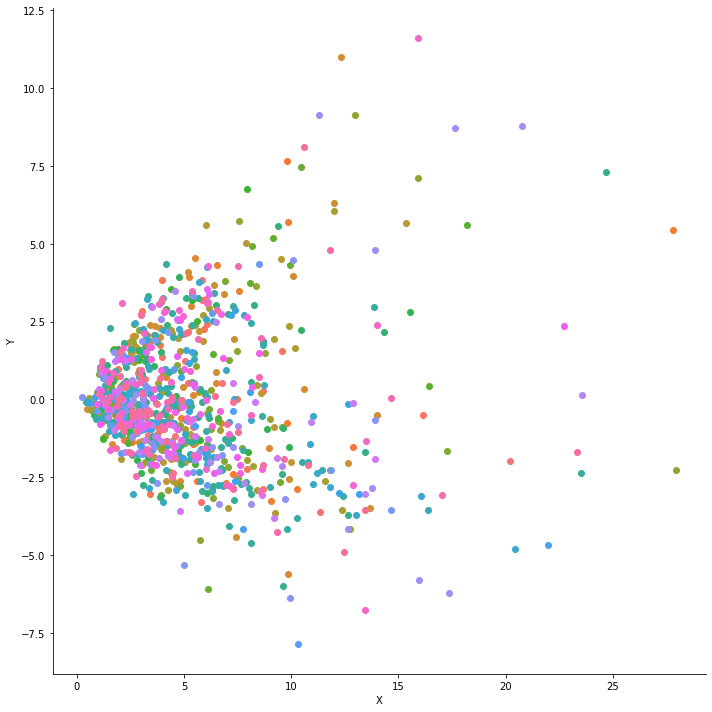

In [162]:
sns.FacetGrid(vis_sample, hue="topic", size = 10).map(plt.scatter, "X", "Y")

Визуализация сэмпла в пределах 1000 строк из датасета не дает какого-то внятного разбиения по кластерам, а на большем количестве данных (уже порядка 10000 и выше) визуализация строится слишком долго.

### Часть 3. Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации.

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [15]:
df_copy = pd.read_csv('responces_cleaned.csv')

In [16]:
# отбираем все записи из датасета с предобработаннм текстом с оценками 1 или 5
df_responces = df_copy[df_copy.rating_grade.isin([1, 5])][['text', 'rating_grade']]
df_responces.head()

,text,rating_grade
19,открыть вклад счёт плюс зарплатный карта рубль...,1.0
33,добрый время вчера поступить смс уведомление б...,1.0
76,г около час прийти указанный офис намерение по...,1.0
85,оплата коммунальный платёж пользоваться пласти...,1.0
94,апрель год прийти отделение сбербанк г чапаевс...,1.0


In [17]:
df_responces.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62100 entries, 19 to 153498
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          62099 non-null  object 
 1   rating_grade  62100 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.4+ MB


In [18]:
df_responces.dropna(inplace=True)

In [19]:
df_responces.rating_grade.value_counts(normalize=True)

1.0    0.763072
5.0    0.236928
Name: rating_grade, dtype: float64

Классы распределены неравномерно, отрицательных отзывов существенно больше, чем положительных. В таких условиях предсказывание моделью всегда варианта рейтинга 1.0 даст 76% accuracy, так что модели есть куда улучшать свой результат. Пока не буду предобрабатывать данные так, чтобы уменьшить дисбаланс классов 

In [20]:
from sklearn.model_selection import train_test_split

In [41]:
# использую параметр stratify, чтобы в обучающей и тестовой выборке соотношение оценок примерно сохранялось
x_train, x_test, y_train, y_test = train_test_split(df_responces.text, df_responces.rating_grade, stratify=df_responces.rating_grade)

In [22]:
print(x_train.shape)
print(x_test.shape)

(46574,)
(15525,)


In [23]:
pd.DataFrame(y_train).value_counts(normalize=True)

rating_grade
1.0             0.763065
5.0             0.236935
dtype: float64

#### Baseline на мешке слов

In [42]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [43]:
clf = LogisticRegression(solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(solver='liblinear')

In [44]:
y_pred = clf.predict(vec.transform(x_test))
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.98      0.97      0.97     11925
         5.0       0.90      0.92      0.91      3600

    accuracy                           0.96     15525
   macro avg       0.94      0.95      0.94     15525
weighted avg       0.96      0.96      0.96     15525



Достаточно неплохо для baseline, без подбора параметров, без сложных преобразований входных данных. Предсказанные метки классов примерно сохраняют пропорцию исходного датасета 

In [33]:
n_grams = [(2, 2), (3, 3)]

In [34]:
# пробую логистическую регрессию для биграмм и триграмм
for n_gram in n_grams:
    vec = CountVectorizer(ngram_range=n_gram)
    bow = vec.fit_transform(x_train)
    clf = LogisticRegression(random_state=146, solver='liblinear')
    clf.fit(bow, y_train)
    y_pred = clf.predict(vec.transform(x_test))
    print(f'N-gramm range={n_gram}:')
    print(classification_report(y_pred, y_test))
    print('------------')
    

N-gramm range=(2, 2):
              precision    recall  f1-score   support

         1.0       0.99      0.95      0.97     12399
         5.0       0.82      0.96      0.88      3126

    accuracy                           0.95     15525
   macro avg       0.90      0.95      0.93     15525
weighted avg       0.95      0.95      0.95     15525

------------
N-gramm range=(3, 3):
              precision    recall  f1-score   support

         1.0       1.00      0.83      0.91     14193
         5.0       0.35      0.97      0.51      1332

    accuracy                           0.84     15525
   macro avg       0.67      0.90      0.71     15525
weighted avg       0.94      0.84      0.87     15525

------------


С использованием биграмм и триграмм результат становится более чувствительным к дисбалансу классов. Модель начинает прогнозировать больше рейтингов 1, precision для оценок 5 падает очень заметно

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
# перед применением Truncated SVD посмотрим, какой результат дат логистическая регрессия
# на данных, преобразованных с помощью tf-idf 

vec = TfidfVectorizer()
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=146, solver='liblinear')
clf.fit(bow, y_train)

y_pred = clf.predict(vec.transform(x_test))
print(classification_report(y_pred, y_test))


              precision    recall  f1-score   support

         1.0       0.99      0.96      0.98     12180
         5.0       0.88      0.97      0.92      3345

    accuracy                           0.96     15525
   macro avg       0.93      0.96      0.95     15525
weighted avg       0.97      0.96      0.96     15525



Результат accuracy такой же, как и для baseline, но f-score обоих классов выше, так что можно считать, что этот вариант отработал немного лучше 

In [45]:
bow.shape

(46574, 57883)

Наша выборка после векторизации стала обладать большим количеством фич. Время для применения TruncatedSVD, чтобы сократить их число.
Для этого переобучу tf-idf на датасете с рейтингами, и разделю на обучающую и тестовую выборки уже после преобразований с SVD

In [46]:
from sklearn.decomposition import TruncatedSVD

In [47]:
vectors = TfidfVectorizer().fit_transform(df_responces.text)

In [48]:
vectors.shape

(62099, 65581)

In [49]:
X_reduced = TruncatedSVD(n_components=100, random_state=0).fit_transform(vectors)

In [50]:
x_train, x_test, y_train, y_test = train_test_split(X_reduced, df_responces.rating_grade, stratify=df_responces.rating_grade)

In [51]:
clf = LogisticRegression(random_state=146, solver='liblinear')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.98      0.95      0.96     12281
         5.0       0.82      0.93      0.87      3244

    accuracy                           0.94     15525
   macro avg       0.90      0.94      0.92     15525
weighted avg       0.95      0.94      0.94     15525



Результат упал ниже baseline. Попробую разное количество фич, оставляемых TruncatedSVD

In [47]:
n_features = [20, 50, 80, 200, 500, 1000]

In [ ]:
for n in n_features:
    X_reduced = TruncatedSVD(n_components=n, random_state=0).fit_transform(vectors)
    x_train, x_test, y_train, y_test = train_test_split(X_reduced, df_responces.rating_grade, stratify=df_responces.rating_grade)
    clf = LogisticRegression(random_state=146, solver='liblinear')
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    print(f'truncatedSVD components: {n}')
    print(classification_report(y_pred, y_test))
    print('---------------------------')
    

truncatedSVD components: 20
              precision    recall  f1-score   support

         1.0       0.97      0.93      0.95     12418
         5.0       0.75      0.88      0.81      3107

    accuracy                           0.92     15525
   macro avg       0.86      0.90      0.88     15525
weighted avg       0.93      0.92      0.92     15525

---------------------------
truncatedSVD components: 50
              precision    recall  f1-score   support

         1.0       0.98      0.94      0.96     12299
         5.0       0.81      0.92      0.86      3226

    accuracy                           0.94     15525
   macro avg       0.89      0.93      0.91     15525
weighted avg       0.94      0.94      0.94     15525

---------------------------
truncatedSVD components: 80
              precision    recall  f1-score   support

         1.0       0.98      0.94      0.96     12311
         5.0       0.81      0.93      0.87      3214

    accuracy                           0.9

In [ ]:
X_reduced = TruncatedSVD(n_components=n, random_state=0).fit_transform(vectors)
x_train, x_test, y_train, y_test = train_test_split(X_reduced, df_responces.rating_grade, stratify=df_responces.rating_grade)
clf = LogisticRegression(random_state=146, solver='liblinear')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
print(f'truncatedSVD components: {n}')
print(classification_report(y_pred, y_test))
print('---------------------------'

Видим, что при относительно малом количество компонентов (<500) итоговые f-score и accuracy меньш, чем для baseline. при этом Уже на 500 компонентах получаю такой же результат, хотя количество фич уменьшено более чем в 100 раз ((62099, 65581) - размерность векторов после применения к датасету tf-idf). Увеличение количества компонентов до 1000 дает еще небольшое улучшение (accuracy остается прежним, но ф-мера немного подрастает). Я пробовала увеличить количеств компонентов до 10000, но это настолько увеличивает время обучения, что дожидаться результатов кажется нецелесообразным. Поэтому для дальнейших экспериментов буду использовать меньшее значение n_components, пусть будет 1000

Попробуем применить к этим же данным другие классификаторы

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [53]:
classifiers = {

    'tree': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(), 
    'knc': KNeighborsClassifier(n_neighbors=10),
    'svc': SVC()
}

In [54]:
X_reduced = TruncatedSVD(n_components=1000, random_state=0).fit_transform(vectors)
x_train, x_test, y_train, y_test = train_test_split(X_reduced, df_responces.rating_grade, stratify=df_responces.rating_grade)

In [55]:
for label, model in classifiers.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'{label} result')
    print(classification_report(y_pred, y_test))
    print('------------------------')

tree result
              precision    recall  f1-score   support

         1.0       0.89      0.89      0.89     11758
         5.0       0.66      0.65      0.66      3767

    accuracy                           0.84     15525
   macro avg       0.78      0.77      0.77     15525
weighted avg       0.83      0.84      0.83     15525

------------------------
rfc result
              precision    recall  f1-score   support

         1.0       1.00      0.84      0.91     14003
         5.0       0.41      0.98      0.57      1522

    accuracy                           0.86     15525
   macro avg       0.70      0.91      0.74     15525
weighted avg       0.94      0.86      0.88     15525

------------------------
knc result
              precision    recall  f1-score   support

         1.0       0.99      0.79      0.88     14962
         5.0       0.14      0.89      0.24       563

    accuracy                           0.79     15525
   macro avg       0.57      0.84      0.56 

Самый лучший результат у модели SVC, и он лучше baseline. Accuracy = 0.97 при достаточных значения полноты и точности 

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:
params = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [1, 10]
}

In [58]:
svc = SVC()
grid_svc = GridSearchCV(svc, param_grid=params)

In [59]:
grid_svc.fit(X_reduced, df_responces.rating_grade)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ['linear', 'rbf', 'sigmoid']})

In [60]:
grid_svc.best_params_

{'C': 10, 'kernel': 'rbf'}

In [61]:
best_svc = grid_svc.best_estimator_

In [63]:
best_svc.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(classification_report(y_pred, y_test))
print('------------------------')

              precision    recall  f1-score   support

         1.0       0.99      0.97      0.98     12098
         5.0       0.89      0.96      0.92      3427

    accuracy                           0.97     15525
   macro avg       0.94      0.96      0.95     15525
weighted avg       0.97      0.97      0.97     15525

------------------------


После попытки подобрать гиперпараметры, результат остался прежним, но это хорошие показатели. Полагаю, на этом можно остановиться